In [1]:
import DataSet
import Evaluation
import datetime
import numpy as np 
import json
import matplotlib.pyplot as plt
import random
from matplotlib.backends.backend_pdf import PdfPages
import sklearn
from Utils import *
import time
from DataSet import UniHHIMUGestures
from torch.utils.data import Dataset, DataLoader

import torch
import torch.nn as nn
import torch.optim as optim
from bayes_opt import BayesianOptimization
from reservoirpy.nodes import Reservoir, Ridge, IPReservoir, FORCE, LMS, RLS, NVAR
from reservoirpy.mat_gen import bernoulli, normal, fast_spectral_initialization, uniform, random_sparse
from reservoirpy.hyper import research
from reservoirpy.utils import verbosity
verbosity(0)

c:\Users\alok2\Downloads\phd\gesture_recognition\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


0

In [2]:
def fix_seed(manualSeed):
    
    np.random.seed(manualSeed)
    random.seed(manualSeed)
    torch.manual_seed(manualSeed)
    # if you are using GPU
    torch.cuda.manual_seed(manualSeed)
    torch.cuda.manual_seed_all(manualSeed)


#torch.backends.cudnn.enabled = False 
#torch.backends.cudnn.benchmark = False
#torch.backends.cudnn.deterministic = True

#===========================================================================
# Give this run a name. 
# If name equals 'test', no log will be generated
#===========================================================================
name = 'test'


#===========================================================================
# Decide which gesture data shall be used for training
#===========================================================================
inputGestures = [0,1,2,3,4,5,6,7,8,9]

#===========================================================================
# Decide which target signals shall be used for training
#===========================================================================
usedGestures = [0,1,2,3,4,5,6,7,8,9]

#===========================================================================
# Concatenate data to create "more" training samples, 1 corresponds to no concatenations
#===========================================================================
concFactor = 1

#===========================================================================
# Add noise to the data, 0 corresponds to no noise. Noise above 2 has shown to weaken recognition
#===========================================================================
noiseFactor = 1

#===========================================================================
# Decide wether gestures shall be shuffled before training. If true, nFolds many 
# pieces will be generated. Not every piece is garanteed to contain every gesture, so do not use too many.
#===========================================================================
shuffle = True
nFolds = 4


#===========================================================================
# Function used to evaluate during cross validation. Possible functions are:
# Evaluation.calc1MinusF1FromMaxApp (best working, used in thesis)
# Oger.utils.nmse (normalised mean square error, tells nothing about classifier perfomance but works okay)
# Evaluation.calcLevenshteinError (use the Levenshtein error, disadvantages are highlighted in thesis) 
# Evaluation.calc1MinusF1FromInputSegment (use segmentation by supervised signal)
#===========================================================================
evaluationFunction = Evaluation.calc1MinusF1FromMaxApp

#===========================================================================
# Set this to true if another output neuron shall be added to represent "no gesture"
#===========================================================================
learnTreshold = False

#===========================================================================
# Use on of the optimisation dictionaries from the optDicts file
#===========================================================================
optDict = 'bestParas'

#===========================================================================
# Use normalizer
#===========================================================================
useNormalized = 2

#===========================================================================
# Pick datasets to train on, and datasets to test on
#===========================================================================
inputFiles = ['s','j','na','l']
testFiles = ['ni']

# If desired add a specific file to test on, e.g. randTestFiles = ['lana_0_0.npz']
randTestFiles = []



#===========================================================================
# Setup project directory
#===========================================================================
now = datetime.datetime.now()
resultsPath = getProjectPath()+'results/'
pdfFileName = now.strftime("%Y-%m-%d-%H-%M")+'_'+name+'.pdf'
pdfFilePath = resultsPath+'pdf/'+pdfFileName
npzFileName = now.strftime("%Y-%m-%d-%H-%M")+'_'+name+'.npz'
npzFilePath = resultsPath+'npz/'+npzFileName
bestFlowPath = resultsPath+'nodes/'+now.strftime("%Y-%m-%d-%H-%M")+'_'+name+'.p'
# pp = PdfPages(pdfFilePath)


#===========================================================================
# Add labels for gestures
#===========================================================================
totalGestureNames = ['left','right','forward','backward','bounce up','bounce down','turn left','turn right','shake lr','shake ud', \
                     'tap 1','tap 2','tap 3','tap 4','tap 5','tap 6','no gesture']
gestureNames = []
for i in usedGestures:
    gestureNames.append(totalGestureNames[i])
gestureNames.append('no gesture')

def createData(inputFiles, testFiles):
    trainset = UniHHIMUGestures(dataDir='dataSets/', 
                                train=True, 
                                inputFiles=inputFiles,
                                testFiles=testFiles,
                                useNormalized=useNormalized, 
                                learnTreshold=learnTreshold,
                                shuffle=True,
                               )

    testset = UniHHIMUGestures(dataDir='dataSets/', 
                               train=False, 
                               inputFiles=inputFiles,
                               testFiles=testFiles,
                               useNormalized=useNormalized, 
                               learnTreshold=learnTreshold,
                               shuffle=True
                              
                              )

    trainloader = DataLoader(trainset, batch_size=1,
                            shuffle=True, num_workers=1)
    testloader = DataLoader(testset, batch_size=1,
                            shuffle=True, num_workers=1)
    return trainset, testset, trainloader, testloader
    
trainset, testset, trainloader, testloader = createData(inputFiles, testFiles)

fix_seed(0)

In [3]:
totalGestureNames = ['left','right','forward','backward','bounce up','bounce down','turn left','turn right','shake lr','shake ud', \
                     'tap 1','tap 2','tap 3','tap 4','tap 5','tap 6','no gesture']
gestureNames = []
for i in usedGestures:
    gestureNames.append(totalGestureNames[i])
gestureNames.append('no gesture')

def createESN(**params):
    ridge = params['ridge']
    del params['ridge']
    params['units'] = int(params['units'])
    reservoir = Reservoir(**params)
    readout = Ridge(output_dim=10, ridge=ridge)
    esn = reservoir >> readout
    return esn

def createIPESN(**params):
    readout = Ridge(output_dim=10, ridge=params['ridge'])
    del params['ridge']
    params['units'] = int(params['units'])
    reservoir = IPReservoir(**params)
    esn = reservoir >> readout
    return esn

def createESNForce(**params):
    readout = FORCE(output_dim=10, alpha=params['alpha'])
    del params['alpha']
    params['units'] = int(params['units'])
    reservoir = Reservoir(**params)
    esn = reservoir >> readout
    return esn

def createESNLms(**params):
    readout = LMS(output_dim=10, alpha=params['alpha'])
    del params['alpha']
    params['units'] = int(params['units'])
    reservoir = Reservoir(**params)
    esn = reservoir >> readout
    return esn
    
def createESNRls(**params):
    readout = RLS(output_dim=10, alpha=params['alpha'])
    del params['alpha']
    params['units'] = int(params['units'])
    reservoir = Reservoir(**params)
    esn = reservoir >> readout
    return esn

def getData(loader):
    x = []
    y = []
    for inputs, targets in loader:
        x.append(inputs[0])
        y.append(targets[0])
    x = np.concatenate(x)
    y = np.concatenate(y)
    return (x, y)

def trainESN(trainloader, esn):
    x, y = getData(trainloader)
    return esn.fit(x, y, warmup=100)

def trainESN2(trainloader, esn):
    x, y = getData(trainloader)
    return esn.train(x, y)

def testESN(esn, testloader, learnTreshold, fixed_threshold=0.4, conf_mat_title="", testFiles=""):
    testF1MaxApps = []
    testAccuracies = []
    if testFiles:
        trainset, testset, trainloader, testloader = createData(inputFiles=testFiles, testFiles=testFiles)

    for test_inputs, test_targets in testloader:
        outputs = esn.run(test_inputs[0])
    
        
        t_target = test_targets[0].numpy()
        prediction = outputs
        if learnTreshold: # if threshold is learned, then it's the last collumn of the prediction
            threshold = outputs[0].numpy()[:,10]
        else: #else add a constant threshold
            threshold = np.ones((prediction.shape[0],1))*fixed_threshold

        t_maxApp_prediction = Evaluation.calcMaxActivityPrediction(prediction,t_target,threshold, 10)


        pred_MaxApp, targ_MaxApp = Evaluation.calcInputSegmentSeries(t_maxApp_prediction, t_target, 0.5)
        testF1MaxApps.append(np.mean(sklearn.metrics.f1_score(targ_MaxApp,pred_MaxApp,average=None)))
        testAccuracies.append(np.mean(sklearn.metrics.accuracy_score(targ_MaxApp,pred_MaxApp)))

        # print("Test f1 score for maxactivity algorithm on testsets {} is {:.2f}, accuracy {:.2} ".format(
        #     testFiles, np.mean(testF1MaxApps), np.mean(testAccuracies)))
    return testF1MaxApps, testAccuracies, targ_MaxApp, pred_MaxApp

def testModel(params, trainFiles, testFiles, numEvals=1, modelCreator=createESN, trainFunc=trainESN):
    scores = []
    accuracies = []
    targets = np.array([])
    preds = np.array([])
    for _ in range(numEvals):
        trainset, testset, trainloader, testloader = createData(inputFiles=trainFiles, testFiles=testFiles)
        esn = modelCreator(**params)
        try:
            trainFunc(trainloader, esn)
        except Exception as e:
            print(e)
            return 0, 0, 0, 0
        bestF1ScoreTreshold = 0.4
        # very good results when bestF1score is set to 0.4

        score, accuracy, target, pred = testESN(esn, testloader, learnTreshold, fixed_threshold=bestF1ScoreTreshold, testFiles=testFiles)
        targets = np.append(targets, target)
        preds = np.append(preds, pred)
        scores.extend(score)
        accuracies.extend(accuracy)
    return (scores, accuracies, targets, preds)

def optimizer(pbounds, modelCreator, trainFunc, numEvals=3):
    files = ['s','j','na','l','ni']
    optimalParams = {}
    f1Scores = []
    accuracies = []
    targets = np.array([])
    preds = np.array([])
    for idx in range(5):
        inputFiles = files[:idx] + files[idx+1:]
        validationFiles = [inputFiles[idx%4]]
        trainFiles = inputFiles[:idx%4] + inputFiles[idx%4+1:]
        testFiles = files[idx:idx+1]
        print(inputFiles, trainFiles, validationFiles, testFiles)

        def black_box_function(**params):
            scores, _, _, _ = testModel(params, trainFiles, validationFiles, numEvals, modelCreator, trainFunc)
            f1 = np.array(scores).mean()
            return f1

        optimizer = BayesianOptimization(
            f=black_box_function,
            pbounds=pbounds,
        )

        optimizer.maximize(
            init_points=15,
            n_iter=15,
        )
        s, a, target, pred = testModel(optimizer.max['params'], inputFiles, testFiles, 20, modelCreator, trainFunc)
        optimalParams[testFiles[0]]=optimizer.max['params']
        print(testFiles, np.array(s).mean(), np.array(s).std(), np.array(a).mean(), np.array(a).std())
        f1Scores+=s
        accuracies+=a
        targets = np.append(targets, target)
        preds = np.append(preds, pred)
    print(np.array(f1Scores).mean(), np.array(f1Scores).std(), np.array(accuracies).mean(), np.array(accuracies).std())
    cm = sklearn.metrics.confusion_matrix(targets, preds)
    Evaluation.plot_confusion_matrix(cm, gestureNames, title="")
    plt.tight_layout()
    plt.ylim(10.5,-0.5)
    return optimalParams

['j', 'na', 'l', 'ni'] ['na', 'l', 'ni'] ['j'] ['s']
|   iter    |  target   |    iss    | learni... |    lr     |    mu     |   ridge   |   sigma   |    sr     |   units   |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  0.6175   |  1.026    |  0.003543 |  0.7549   | -0.1408   |  9.941e-0 |  0.682    |  0.7046   |  813.4    |
|  2        |  0.8787   |  1.053    |  0.009621 |  0.314    | -0.06744  |  1.257e-0 |  0.4569   |  1.137    |  385.8    |
|  3        |  0.0859   |  0.9339   |  0.001431 |  0.01526  | -0.002638 |  2.545e-0 |  1.843    |  0.6095   |  733.9    |
|  4        |  0.6518   |  0.935    |  0.00785  |  0.4399   |  0.1331   |  5.444e-0 |  1.142    |  0.9098   |  466.4    |
|  5        |  0.2007   |  0.9409   |  0.003205 |  0.1827   |  0.0512   |  2.954e-0 |  1.926    |  1.684    |  903.8    |
|  6        |  0.2566   |  0.8852   |  0.005671 |  0.1604   |  0.1461   |  4.334e-0 |  0.0073

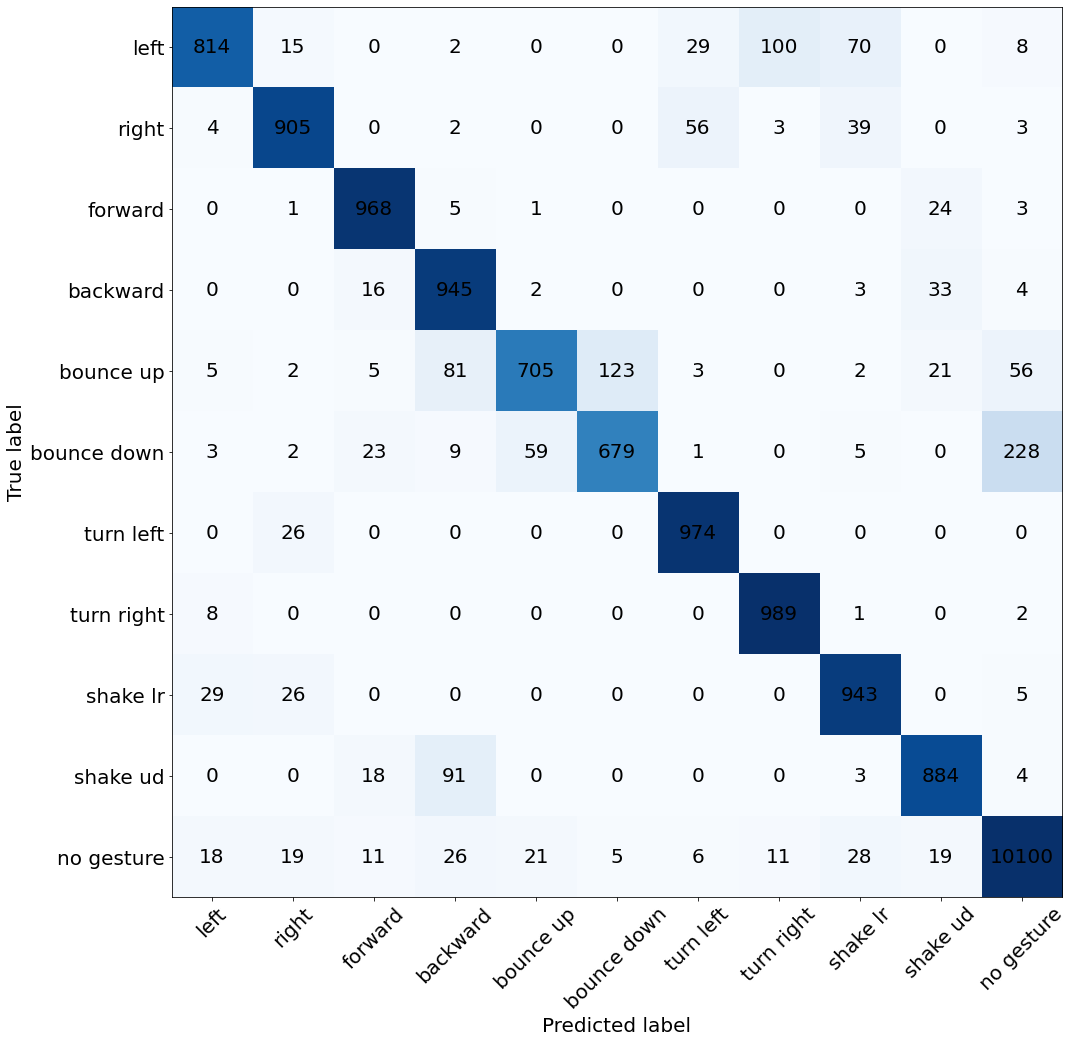

In [ ]:
pbounds = {'units': (100, 1000), 'lr': (0, 1), 'sr': (0.5, 2), 'mu': (-0.2, 0.2), 'sigma': (0, 2), 'learning_rate': (1e-2, 1e-5), 'iss': (0.8, 1.2), 'ridge': (0, 1e-4)}
optimalParams = optimizer(pbounds, createIPESN, trainESN, 2)
print(optimalParams)

In [ ]:
def rollingWindow(data, windowSize=50):
    rollingData = []
    for i in range(windowSize, data.shape[0]):
        rollingData.append(data[i-windowSize:i])
    return np.array(rollingData[:len(rollingData)//2])

def createReservoir(**params):
    params['units'] = int(params['units'])
    reservoir = Reservoir(**params)
    return reservoir

def createIPReservoir(**params):
    params['units'] = int(params['units'])
    reservoir = IPReservoir(**params)
    return reservoir

def calculateSeperability(params, creator, testSet):
    reservoir = creator(**params)
    trainset, testset, trainloader, testloader = createData(inputFiles=testSet, testFiles=['ni'])
    x, y = getData(trainloader)
    # x = x[:x.shape[0]-x.shape[0]%20,]
    inputs = rollingWindow(x)
    matrix = np.ndarray((reservoir.units, inputs.shape[0]))
    for i in range(inputs.shape[0]):
        pred = reservoir.run(inputs[i])[-1]
        matrix[:, i] = pred
    return np.linalg.matrix_rank(np.matrix.transpose(matrix))

def calculateGeneralization(params, creator, testSet):
    reservoir = creator(**params)
    trainset, testset, trainloader, testloader = createData(inputFiles=testSet, testFiles=['ni'])
    x, y = getData(trainloader)
    # x = x[:x.shape[0]-x.shape[0]%20,]
    inputs = rollingWindow(x)
    noise = np.random.rand(*inputs.shape)*0.1
    inputs = inputs+noise
    matrix = np.ndarray((reservoir.units, inputs.shape[0]))
    for i in range(inputs.shape[0]):
        pred = reservoir.run(inputs[i])[-1]
        matrix[:, i] = pred
    return np.linalg.matrix_rank(matrix)

def memoryCapacity(params, creator, numInputs=1, trainSize = 5000):
    reservoir = creator(**params)
    maxDelay = 30
    capacity = 0
    readout = Ridge(output_dim=1, ridge=1e-5)
    esn = reservoir>>readout
    for i in range(maxDelay):
        randomSeries = np.random.rand(trainSize+i, numInputs)
        targets = randomSeries[0:trainSize]
        inputs = randomSeries[i:]
        try:
            esn.fit(inputs, targets)
        except:
            print("Failed to train a model")
        newRandomSeries = np.random.rand(trainSize+i, numInputs)
        preds = np.squeeze(esn.run(newRandomSeries)[i:])
        cov = abs(np.cov(np.squeeze(newRandomSeries[0:trainSize]), preds)[0, -1])
        v1 = np.var(np.squeeze(newRandomSeries[0:trainSize]))
        v2 = np.var(preds)
        capacity+=cov*cov/(v1*v2)
    return capacity

def getBehaviourSpace(reservoirs):
    seperability = []
    generalizability = []
    mc = []
    scores = []
    for reservoirParams in reservoirs:
        print("GETTING BEHAVIOR SPACE")
        score = reservoirParams['score']
        scores.append(score)
        creator = reservoirParams['creator']
        seperability.append(calculateSeperability(reservoirParams['params'], creator, reservoirParams['testSet']))
        generalizability.append(calculateGeneralization(reservoirParams['params'], creator, reservoirParams['testSet']))
        mc.append(memoryCapacity(reservoirParams['params'], creator))
    return seperability, generalizability, mc, scores

def optimizer(pbounds, modelCreator, trainFunc, numEvals=1):
    files = ['s','j','na','l','ni']
    optimalParams = {}
    allParams = []
    f1Scores = []
    accuracies = []
    targets = np.array([])
    preds = np.array([])
    for idx in range(5):
        p = []
        inputFiles = files[:idx] + files[idx+1:]
        validationFiles = [inputFiles[idx%4]]
        trainFiles = inputFiles[:idx%4] + inputFiles[idx%4+1:]
        testFiles = files[idx:idx+1]
        print("BEGINNING TRAINING FOR", testFiles)

        def black_box_function(**params):
            scores, _, _, _ = testModel(params, trainFiles, validationFiles, numEvals, modelCreator, trainFunc)
            f1 = np.array(scores).mean()
            return f1

        optimizer = BayesianOptimization(
            f=black_box_function,
            pbounds=pbounds,
        )

        optimizer.maximize(
            init_points=15,
            n_iter=15,
        )
        for score, params in zip(optimizer._space._target, optimizer._space._params):
            params = optimizer._space.array_to_params(params)
            del params['ridge']
            params['units'] = int(params['units'])
            p.append({'params':params, 'score': score, 'creator':createIPReservoir, 'testSet': testFiles})
        x, y, c, z = getBehaviourSpace(p)
        makeGraph(x, y, c, z)
    return allParams

In [ ]:
%matplotlib inline
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

def makeGraph(x, y, z, c):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    p = ax.scatter(x, y, z, c=c, cmap='viridis', linewidth=0.5)
    ax.set_xlabel('$KR$')
    ax.set_ylabel('$GR$')
    ax.set_zlabel(r'$MC$')
    fig.colorbar(p)

BEGINNING TRAINING FOR ['s']
|   iter    |  target   |    iss    | learni... |    lr     |    mu     |   ridge   |   sigma   |    sr     |   units   |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  0.6156   |  1.033    |  0.002316 |  0.09981  |  0.1053   |  8.254e-0 |  0.3843   |  1.067    |  200.8    |
|  2        |  0.5071   |  0.801    |  0.008237 |  0.3331   | -0.02774  |  9.271e-0 |  1.341    |  1.164    |  503.9    |
|  3        |  0.5312   |  0.8971   |  0.006325 |  0.5123   | -0.1821   |  3.435e-0 |  1.002    |  1.852    |  909.0    |
|  4        |  0.4411   |  1.175    |  0.00293  |  0.6385   | -0.08105  |  6.088e-0 |  1.382    |  0.9687   |  706.0    |
|  5        |  0.9004   |  0.9128   |  0.005923 |  0.3757   |  0.07313  |  4.895e-0 |  0.3613   |  1.483    |  427.7    |
|  6        |  0.3884   |  0.964    |  0.006535 |  0.9981   |  0.1128   |  4.256e-0 |  1.903    |  0.5721   |  656.6 

/usr/local/lib/python3.7/dist-packages/reservoirpy/nodes/reservoirs/intrinsic_plasticity.py:31: RuntimeWarning: divide by zero encountered in double_scalars
  delta_b = -eta * (-(mu / sig2) + (y / sig2) * (2 * sig2 + 1 - y**2 + mu * y))
/usr/local/lib/python3.7/dist-packages/reservoirpy/nodes/reservoirs/intrinsic_plasticity.py:31: RuntimeWarning: invalid value encountered in true_divide
  delta_b = -eta * (-(mu / sig2) + (y / sig2) * (2 * sig2 + 1 - y**2 + mu * y))


array must not contain infs or NaNs
|  21       |  0.0      |  1.2      |  1e-05    |  0.0      | -0.2      |  0.0      |  0.0      |  0.888    |  346.5    |
|  22       |  0.3244   |  0.8982   |  0.002984 |  0.6276   |  0.01133  |  6.734e-0 |  0.8975   |  1.934    |  347.3    |
|  23       |  0.8971   |  0.8002   |  0.005635 |  0.3501   | -0.1539   |  6.518e-0 |  0.6817   |  0.6604   |  346.9    |
|  24       |  0.597    |  0.9962   |  0.002904 |  0.6146   | -0.1969   |  5.012e-0 |  1.89     |  1.201    |  973.3    |
|  25       |  0.938    |  0.8658   |  0.00665  |  0.5707   |  0.01169  |  9.011e-0 |  0.4519   |  0.6012   |  346.9    |
|  26       |  0.3602   |  0.8218   |  0.002284 |  0.8695   | -0.04273  |  3.321e-0 |  1.771    |  1.179    |  739.1    |
|  27       |  0.6639   |  1.124    |  0.00148  |  0.3006   |  0.01793  |  4.935e-0 |  0.6126   |  0.7746   |  347.3    |
|  28       |  0.6081   |  1.166    |  0.009797 |  0.2372   |  0.1542   |  9.238e-0 |  1.275    |  1.258    | 

/usr/local/lib/python3.7/dist-packages/reservoirpy/nodes/reservoirs/intrinsic_plasticity.py:31: RuntimeWarning: divide by zero encountered in double_scalars
  delta_b = -eta * (-(mu / sig2) + (y / sig2) * (2 * sig2 + 1 - y**2 + mu * y))
/usr/local/lib/python3.7/dist-packages/reservoirpy/nodes/reservoirs/intrinsic_plasticity.py:31: RuntimeWarning: invalid value encountered in true_divide
  delta_b = -eta * (-(mu / sig2) + (y / sig2) * (2 * sig2 + 1 - y**2 + mu * y))


Failed to train a model
Failed to train a model
Failed to train a model
Failed to train a model
Failed to train a model
Failed to train a model
Failed to train a model
Failed to train a model
Failed to train a model
Failed to train a model
Failed to train a model
Failed to train a model
Failed to train a model
Failed to train a model
Failed to train a model
Failed to train a model
Failed to train a model
Failed to train a model
Failed to train a model
Failed to train a model
Failed to train a model
Failed to train a model
Failed to train a model
Failed to train a model
Failed to train a model
Failed to train a model
Failed to train a model
Failed to train a model
Failed to train a model
Failed to train a model
GETTING BEHAVIOR SPACE
GETTING BEHAVIOR SPACE
GETTING BEHAVIOR SPACE
GETTING BEHAVIOR SPACE
GETTING BEHAVIOR SPACE
GETTING BEHAVIOR SPACE
GETTING BEHAVIOR SPACE
GETTING BEHAVIOR SPACE
GETTING BEHAVIOR SPACE
BEGINNING TRAINING FOR ['na']
|   iter    |  target   |    iss    | learn

/usr/local/lib/python3.7/dist-packages/reservoirpy/nodes/reservoirs/intrinsic_plasticity.py:31: RuntimeWarning: divide by zero encountered in double_scalars
  delta_b = -eta * (-(mu / sig2) + (y / sig2) * (2 * sig2 + 1 - y**2 + mu * y))
/usr/local/lib/python3.7/dist-packages/reservoirpy/nodes/reservoirs/intrinsic_plasticity.py:31: RuntimeWarning: divide by zero encountered in true_divide
  delta_b = -eta * (-(mu / sig2) + (y / sig2) * (2 * sig2 + 1 - y**2 + mu * y))
/usr/local/lib/python3.7/dist-packages/reservoirpy/nodes/reservoirs/intrinsic_plasticity.py:31: RuntimeWarning: invalid value encountered in add
  delta_b = -eta * (-(mu / sig2) + (y / sig2) * (2 * sig2 + 1 - y**2 + mu * y))
/usr/local/lib/python3.7/dist-packages/reservoirpy/nodes/reservoirs/intrinsic_plasticity.py:79: RuntimeWarning: invalid value encountered in add
  return f(a * state + b)


array must not contain infs or NaNs
|  16       |  0.0      |  0.8      |  1e-05    |  0.9963   |  0.1304   |  0.0001   |  0.0      |  2.0      |  798.7    |
|  17       |  0.8337   |  0.9242   |  0.004005 |  0.7108   |  0.01593  |  3.173e-0 |  0.2219   |  1.361    |  791.0    |
|  18       |  0.7277   |  0.8661   |  0.003316 |  0.926    |  0.0194   |  9.212e-0 |  0.9607   |  0.6616   |  709.9    |
|  19       |  0.5205   |  1.109    |  0.002158 |  0.4993   | -0.151    |  8.31e-05 |  0.8868   |  0.9786   |  735.2    |


/usr/local/lib/python3.7/dist-packages/reservoirpy/nodes/reservoirs/intrinsic_plasticity.py:31: RuntimeWarning: divide by zero encountered in double_scalars
  delta_b = -eta * (-(mu / sig2) + (y / sig2) * (2 * sig2 + 1 - y**2 + mu * y))
/usr/local/lib/python3.7/dist-packages/reservoirpy/nodes/reservoirs/intrinsic_plasticity.py:31: RuntimeWarning: divide by zero encountered in true_divide
  delta_b = -eta * (-(mu / sig2) + (y / sig2) * (2 * sig2 + 1 - y**2 + mu * y))
/usr/local/lib/python3.7/dist-packages/reservoirpy/nodes/reservoirs/intrinsic_plasticity.py:31: RuntimeWarning: invalid value encountered in add
  delta_b = -eta * (-(mu / sig2) + (y / sig2) * (2 * sig2 + 1 - y**2 + mu * y))
/usr/local/lib/python3.7/dist-packages/reservoirpy/nodes/reservoirs/intrinsic_plasticity.py:79: RuntimeWarning: invalid value encountered in add
  return f(a * state + b)


array must not contain infs or NaNs
|  20       |  0.0      |  0.8      |  0.008249 |  0.4564   |  0.09463  |  8.523e-0 |  0.0      |  1.287    |  741.9    |
|  21       |  0.3246   |  0.9456   |  0.00523  |  0.3396   |  0.0961   |  7.058e-0 |  1.676    |  1.414    |  792.3    |
|  22       |  0.5375   |  1.106    |  0.009341 |  0.4878   | -0.1666   |  7.003e-0 |  1.832    |  1.579    |  133.1    |
|  23       |  0.8875   |  1.086    |  0.007871 |  0.5808   |  0.006812 |  2.522e-0 |  0.4257   |  0.9536   |  919.4    |
|  24       |  0.3738   |  0.8549   |  0.004454 |  0.3025   |  0.08587  |  4.459e-0 |  0.9971   |  1.823    |  669.5    |
|  25       |  0.8318   |  1.184    |  0.006838 |  0.5996   | -0.1691   |  7.663e-0 |  1.69     |  1.349    |  415.2    |
|  26       |  0.6126   |  1.161    |  0.006758 |  0.4769   |  0.09447  |  6.639e-0 |  1.849    |  1.057    |  167.0    |
|  27       |  0.7858   |  0.9747   |  0.00828  |  0.6537   | -0.1156   |  7.914e-0 |  1.408    |  0.5817   | 

/usr/local/lib/python3.7/dist-packages/reservoirpy/nodes/reservoirs/intrinsic_plasticity.py:31: RuntimeWarning: divide by zero encountered in double_scalars
  delta_b = -eta * (-(mu / sig2) + (y / sig2) * (2 * sig2 + 1 - y**2 + mu * y))
/usr/local/lib/python3.7/dist-packages/reservoirpy/nodes/reservoirs/intrinsic_plasticity.py:31: RuntimeWarning: divide by zero encountered in true_divide
  delta_b = -eta * (-(mu / sig2) + (y / sig2) * (2 * sig2 + 1 - y**2 + mu * y))
/usr/local/lib/python3.7/dist-packages/reservoirpy/nodes/reservoirs/intrinsic_plasticity.py:31: RuntimeWarning: invalid value encountered in true_divide
  delta_b = -eta * (-(mu / sig2) + (y / sig2) * (2 * sig2 + 1 - y**2 + mu * y))
/usr/local/lib/python3.7/dist-packages/reservoirpy/nodes/reservoirs/intrinsic_plasticity.py:31: RuntimeWarning: invalid value encountered in add
  delta_b = -eta * (-(mu / sig2) + (y / sig2) * (2 * sig2 + 1 - y**2 + mu * y))
/usr/local/lib/python3.7/dist-packages/reservoirpy/nodes/reservoirs/int

Failed to train a model
Failed to train a model
Failed to train a model
Failed to train a model
Failed to train a model
Failed to train a model
Failed to train a model
Failed to train a model
Failed to train a model
Failed to train a model
Failed to train a model
Failed to train a model
Failed to train a model
Failed to train a model
Failed to train a model
Failed to train a model
Failed to train a model
Failed to train a model
Failed to train a model
Failed to train a model
Failed to train a model
Failed to train a model
Failed to train a model
Failed to train a model
Failed to train a model
Failed to train a model
Failed to train a model
Failed to train a model
Failed to train a model
Failed to train a model
GETTING BEHAVIOR SPACE
GETTING BEHAVIOR SPACE
GETTING BEHAVIOR SPACE
GETTING BEHAVIOR SPACE
Failed to train a model
Failed to train a model
Failed to train a model
Failed to train a model
Failed to train a model
Failed to train a model
Failed to train a model
Failed to train a mo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in double_scalars


GETTING BEHAVIOR SPACE
GETTING BEHAVIOR SPACE
GETTING BEHAVIOR SPACE
GETTING BEHAVIOR SPACE
GETTING BEHAVIOR SPACE
GETTING BEHAVIOR SPACE
GETTING BEHAVIOR SPACE
GETTING BEHAVIOR SPACE
GETTING BEHAVIOR SPACE


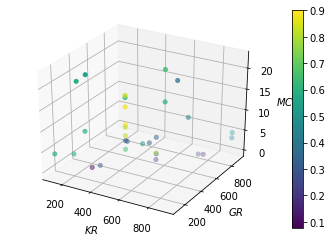

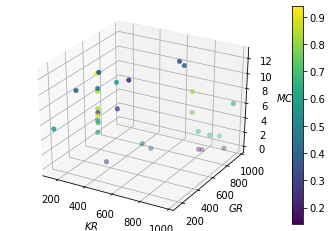

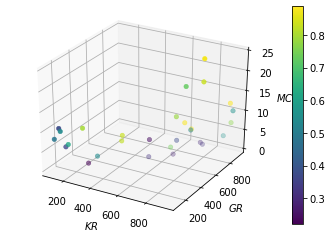

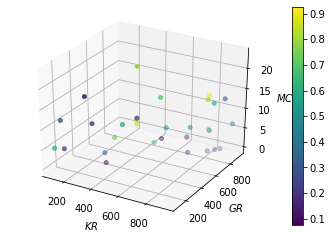

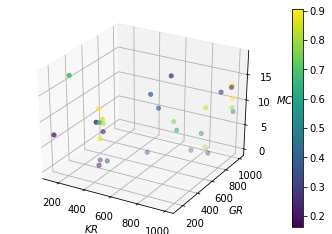

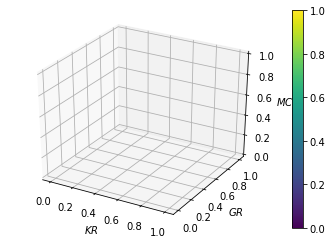

In [ ]:
pbounds = {'units': (100, 1000), 'lr': (0, 1), 'sr': (0.5, 2), 'mu': (-0.2, 0.2), 'sigma': (0, 2), 'learning_rate': (1e-5, 1e-2), 'iss': (0.8, 1.2), 'ridge': (0, 1e-4)}
params = optimizer(pbounds, createIPESN, trainESN, 2)
x, y, c, z = getBehaviourSpace(params)
makeGraph(x, y, c, z)

# Individual model

In [14]:
def getData(loader):
    x = []
    y = []
    for inputs, targets in loader:
        x.append(inputs[0])
        y.append(targets[0])
    x = np.concatenate(x)
    y = np.concatenate(y)
    return (x, y)

def trainESN(trainloader, esn, fraction):
    x, y = getData(trainloader)
    x = x[:int(x.shape[0]*fraction)]
    y = y[:int(y.shape[0]*fraction)]
    return esn.fit(x, y, warmup=100)

def trainESN2(trainloader, esn):
    x, y = getData(trainloader)
    return esn.train(x, y)

def testESN(esn, testloader, learnTreshold, evalRange, fixed_threshold=0.4, conf_mat_title="", testFiles=""):
    testF1MaxApps = []
    testAccuracies = []
    if testFiles:
        trainset, testset, trainloader, testloader = createData(inputFiles=testFiles, testFiles=testFiles)

    for test_inputs, test_targets in testloader:
        outputs = esn.run(test_inputs[0][evalRange])
    
        
        t_target = test_targets[0][evalRange].numpy()
        prediction = outputs
        if learnTreshold: # if threshold is learned, then it's the last collumn of the prediction
            threshold = outputs[0].numpy()[:,10]
        else: #else add a constant threshold
            threshold = np.ones((prediction.shape[0],1))*fixed_threshold

        t_maxApp_prediction = Evaluation.calcMaxActivityPrediction(prediction,t_target,threshold, 10)


        pred_MaxApp, targ_MaxApp = Evaluation.calcInputSegmentSeries(t_maxApp_prediction, t_target, 0.5)
        testF1MaxApps.append(np.mean(sklearn.metrics.f1_score(targ_MaxApp,pred_MaxApp,average=None)))
        testAccuracies.append(np.mean(sklearn.metrics.accuracy_score(targ_MaxApp,pred_MaxApp)))

        # print("Test f1 score for maxactivity algorithm on testsets {} is {:.2f}, accuracy {:.2} ".format(
        #     testFiles, np.mean(testF1MaxApps), np.mean(testAccuracies)))
    return testF1MaxApps, testAccuracies, targ_MaxApp, pred_MaxApp

def testModel(params, evalRange, subjectFiles, trainFraction, numEvals=1, modelCreator=createESN, trainFunc=trainESN):
    scores = []
    accuracies = []
    targets = np.array([])
    preds = np.array([])
    for _ in range(numEvals):
        trainset, testset, trainloader, testloader = createData(inputFiles=subjectFiles, testFiles=subjectFiles)
        esn = modelCreator(**params)
        try:
            trainFunc(trainloader, esn, trainFraction)
        except Exception as e:
            print(e)
            return 0, 0, 0, 0
        bestF1ScoreTreshold = 0.4
        # very good results when bestF1score is set to 0.4

        score, accuracy, target, pred = testESN(esn, testloader, learnTreshold, evalRange, fixed_threshold=bestF1ScoreTreshold, testFiles=subjectFiles)
        targets = np.append(targets, target)
        preds = np.append(preds, pred)
        scores.extend(score)
        accuracies.extend(accuracy)
    return (scores, accuracies, targets, preds)

def optimizer(pbounds, modelCreator, trainFunc, trainFraction=0.6, valFraction=0.2, numEvals=3):
    files = ['s', 'j', 'na','l','ni']
    optimalParams = {}
    f1Scores = []
    accuracies = []
    targets = np.array([])
    preds = np.array([])
    for idx in range(5):
        trainFiles = [files[idx]]
        testFiles = [files[idx]]
        trainset, testset, trainloader, testloader = createData(inputFiles=testFiles, testFiles=testFiles)


        valRange = []
        for test_inputs, test_targets in testloader:
            valRange = range(int(test_inputs[0].shape[0]*0.6), int(test_inputs[0].shape[0]*(0.6+0.2))-1)
        def black_box_function(**params):
            scores, _, _, _ = testModel(params, valRange, trainFiles, trainFraction, numEvals, modelCreator, trainFunc)
            f1 = np.array(scores).mean()
            return f1

        optimizer = BayesianOptimization(
            f=black_box_function,
            pbounds=pbounds,
        )

        optimizer.maximize(
            init_points=15,
            n_iter=15,
        )
        testRange = []
        for test_inputs, test_targets in testloader:
            testRange = range(int(test_inputs[0].shape[0]*(0.6+0.2)), test_inputs[0].shape[0]-1)
        s, a, target, pred = testModel(optimizer.max['params'], testRange, trainFiles, trainFraction+valFraction, 10, modelCreator, trainFunc)
        optimalParams[testFiles[0]]=optimizer.max['params']
        print(testFiles, np.array(s).mean(), np.array(s).std(), np.array(a).mean(), np.array(a).std())
        f1Scores+=s
        accuracies+=a
        targets = np.append(targets, target)
        preds = np.append(preds, pred)
    print(np.array(f1Scores).mean(), np.array(f1Scores).std(), np.array(accuracies).mean(), np.array(accuracies).std())
    cm = sklearn.metrics.confusion_matrix(targets, preds)
    Evaluation.plot_confusion_matrix(cm, gestureNames, title="")
    plt.tight_layout()
    plt.ylim(10.5,-0.5)
    return optimalParams

|   iter    |  target   |    iss    | learni... |    lr     |    mu     |   ridge   |   sigma   |    sr     |   units   |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  0.4502   |  1.083    |  0.004183 |  0.7554   |  0.1161   |  5.252e-0 |  1.093    |  1.205    |  947.3    |
|  2        |  0.9316   |  0.9481   |  0.004379 |  0.3821   |  0.01127  |  3.075e-0 |  0.1951   |  1.102    |  685.0    |
|  3        |  0.716    |  1.095    |  0.000982 |  0.62     |  0.1104   |  1.615e-0 |  1.029    |  0.9229   |  286.9    |
|  4        |  0.8095   |  0.9515   |  0.002661 |  0.6919   |  0.07957  |  7.268e-0 |  0.5616   |  1.364    |  709.2    |
|  5        |  0.6888   |  1.03     |  0.009675 |  0.7816   |  0.07988  |  2.425e-0 |  1.53     |  0.6366   |  208.2    |
|  6        |  0.2516   |  1.143    |  0.003087 |  0.1634   | -0.06461  |  6.431e-0 |  0.7158   |  1.051    |  877.0    |
|  7        |  0.2632   

/usr/local/lib/python3.7/dist-packages/reservoirpy/nodes/reservoirs/intrinsic_plasticity.py:31: RuntimeWarning: divide by zero encountered in double_scalars
  delta_b = -eta * (-(mu / sig2) + (y / sig2) * (2 * sig2 + 1 - y**2 + mu * y))
/usr/local/lib/python3.7/dist-packages/reservoirpy/nodes/reservoirs/intrinsic_plasticity.py:31: RuntimeWarning: divide by zero encountered in true_divide
  delta_b = -eta * (-(mu / sig2) + (y / sig2) * (2 * sig2 + 1 - y**2 + mu * y))
/usr/local/lib/python3.7/dist-packages/reservoirpy/nodes/reservoirs/intrinsic_plasticity.py:31: RuntimeWarning: invalid value encountered in add
  delta_b = -eta * (-(mu / sig2) + (y / sig2) * (2 * sig2 + 1 - y**2 + mu * y))
/usr/local/lib/python3.7/dist-packages/reservoirpy/nodes/reservoirs/intrinsic_plasticity.py:79: RuntimeWarning: invalid value encountered in add
  return f(a * state + b)


array must not contain infs or NaNs
|  25       |  0.0      |  1.2      |  0.004206 |  0.8517   | -0.2      |  8.742e-0 |  0.0      |  0.8927   |  389.3    |
|  26       |  0.9675   |  1.2      |  0.006728 |  0.2678   | -0.1031   |  8.201e-0 |  0.8077   |  0.9217   |  106.7    |
|  27       |  0.3247   |  0.8328   |  0.000153 |  0.8682   | -0.04984  |  6.726e-0 |  0.5695   |  1.607    |  388.2    |
|  28       |  1.0      |  1.144    |  0.004746 |  0.5039   |  0.1449   |  2.968e-0 |  0.3394   |  1.159    |  388.3    |
|  29       |  0.5996   |  0.8543   |  0.009428 |  0.2416   | -0.1562   |  6.388e-0 |  0.8758   |  1.054    |  107.0    |
|  30       |  0.6485   |  1.118    |  0.00226  |  0.9875   |  0.1915   |  9.562e-0 |  0.6206   |  1.608    |  858.5    |
['j'] 0.9898725460585925 0.016181360879012327 0.9931266149870801 0.010502660188799985
|   iter    |  target   |    iss    | learni... |    lr     |    mu     |   ridge   |   sigma   |    sr     |   units   |
------------------------

/usr/local/lib/python3.7/dist-packages/reservoirpy/nodes/reservoirs/intrinsic_plasticity.py:31: RuntimeWarning: divide by zero encountered in double_scalars
  delta_b = -eta * (-(mu / sig2) + (y / sig2) * (2 * sig2 + 1 - y**2 + mu * y))
/usr/local/lib/python3.7/dist-packages/reservoirpy/nodes/reservoirs/intrinsic_plasticity.py:31: RuntimeWarning: divide by zero encountered in true_divide
  delta_b = -eta * (-(mu / sig2) + (y / sig2) * (2 * sig2 + 1 - y**2 + mu * y))
/usr/local/lib/python3.7/dist-packages/reservoirpy/nodes/reservoirs/intrinsic_plasticity.py:31: RuntimeWarning: invalid value encountered in add
  delta_b = -eta * (-(mu / sig2) + (y / sig2) * (2 * sig2 + 1 - y**2 + mu * y))
/usr/local/lib/python3.7/dist-packages/reservoirpy/nodes/reservoirs/intrinsic_plasticity.py:79: RuntimeWarning: invalid value encountered in add
  return f(a * state + b)


array must not contain infs or NaNs
|  21       |  0.0      |  1.086    |  0.01     |  0.9916   |  0.09944  |  0.0      |  0.0      |  0.5      |  653.4    |
|  22       |  0.7872   |  1.098    |  0.00513  |  0.4999   | -0.05973  |  9.052e-0 |  0.6379   |  1.084    |  379.7    |
|  23       |  0.4376   |  0.8009   |  0.000239 |  0.3137   | -0.1153   |  3.363e-0 |  1.057    |  1.335    |  231.8    |
|  24       |  0.4464   |  0.9925   |  0.001104 |  0.4982   | -0.1074   |  2.372e-0 |  0.7236   |  1.595    |  584.6    |
|  25       |  0.9533   |  1.189    |  0.006221 |  0.5262   |  0.05526  |  1.896e-0 |  0.07003  |  1.506    |  541.5    |
|  26       |  0.1285   |  1.08     |  0.003197 |  0.07604  | -0.03189  |  4.92e-05 |  0.04272  |  0.5402   |  453.4    |
|  27       |  0.9727   |  1.144    |  0.003046 |  0.6477   | -0.02929  |  2.324e-0 |  0.4039   |  0.5155   |  261.0    |
|  28       |  0.8951   |  1.04     |  0.00254  |  0.8519   | -0.1004   |  3.454e-0 |  0.2701   |  0.5528   | 

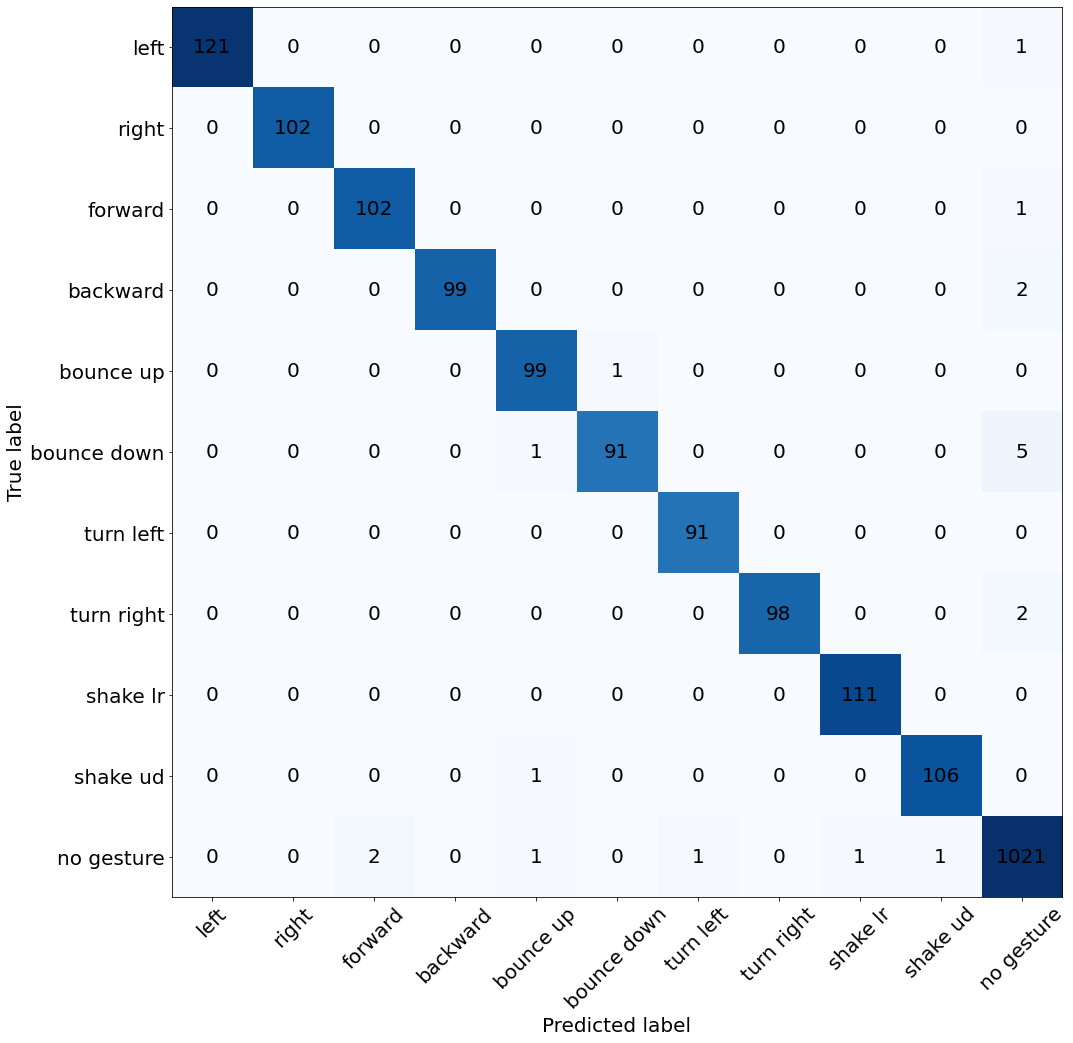

In [15]:
pbounds = {'units': (100, 1000), 'lr': (0, 1), 'sr': (0.5, 2), 'mu': (-0.2, 0.2), 'sigma': (0, 2), 'learning_rate': (1e-5, 1e-2), 'iss': (0.8, 1.2), 'ridge': (0, 1e-4)}
optimalParams = optimizer(pbounds, createIPESN, trainESN, 2)
print(optimalParams)

# Global Model

In [10]:
def getData(loader, fraction):
    x = []
    y = []
    for inputs, targets in loader:
        x.append(inputs[0][:int(inputs[0].shape[0]*fraction)])
        y.append(targets[0][:int(targets[0].shape[0]*fraction)])
    x = np.concatenate(x)
    y = np.concatenate(y)
    return (x, y)

def trainESN(trainloader, esn, fraction):
    x, y = getData(trainloader, fraction)
    return esn.fit(x, y, warmup=100)

def testESN(esn, files, trainFraction, valFraction, isVal, fixed_threshold=0.4):
    testF1MaxApps = []
    testAccuracies = []
    trainset, testset, trainloader, testloader = createData(inputFiles=files, testFiles=files)

    for test_inputs, test_targets in testloader:
        if isVal:
            testRange = range(int(test_inputs[0].shape[0]*trainFraction), int(test_inputs[0].shape[0]*(trainFraction+valFraction)))
        else:
            testRange = range(int(test_inputs[0].shape[0]*(trainFraction+valFraction)), int(test_inputs[0].shape[0]))
            
        outputs = esn.run(test_inputs[0][testRange])

        
        t_target = test_targets[0][testRange].numpy()
        prediction = outputs
        if learnTreshold: # if threshold is learned, then it's the last collumn of the prediction
            threshold = outputs[0].numpy()[:,10]
        else: #else add a constant threshold
            threshold = np.ones((prediction.shape[0],1))*fixed_threshold

        t_maxApp_prediction = Evaluation.calcMaxActivityPrediction(prediction,t_target,threshold, 10)

        pred_MaxApp, targ_MaxApp = Evaluation.calcInputSegmentSeries(t_maxApp_prediction, t_target, 0.5)
        testF1MaxApps.append(np.mean(sklearn.metrics.f1_score(targ_MaxApp,pred_MaxApp,average=None)))
        testAccuracies.append(np.mean(sklearn.metrics.accuracy_score(targ_MaxApp,pred_MaxApp)))

        # print("Test f1 score for maxactivity algorithm on testsets {} is {:.2f}, accuracy {:.2} ".format(
        #     testFiles, np.mean(testF1MaxApps), np.mean(testAccuracies)))
    return testF1MaxApps, testAccuracies

def testModelFinal(params, files, trainFraction, valFraction, numEvals=1, modelCreator=createESN, trainFunc=trainESN):
    scores = {}
    accuracies = {}
    for eachFile in files:
        scores[eachFile] = []
        accuracies[eachFile] = []
    for _ in range(numEvals):
        trainset, testset, trainloader, testloader = createData(inputFiles=files, testFiles=files)
        esn = modelCreator(**params)
        try:
            trainFunc(trainloader, esn, trainFraction+valFraction)
        except Exception as e:
            print(e)
            return 0, 0, 0, 0
        bestF1ScoreTreshold = 0.4
        # very good results when bestF1score is set to 0.4
        
        for eachFile in files:
            s, a = testESN(esn, [eachFile], trainFraction, valFraction, False)
            scores[eachFile].append(s)
            accuracies[eachFile].append(a)
    for f in files:
        scores[f] = np.mean(np.array(scores[f]))
        accuracies[f] = np.mean(np.array(accuracies[f]))
    return (scores, accuracies)

def testModel(params, files, trainFraction, valFraction, numEvals=1, modelCreator=createESN, trainFunc=trainESN):
    scores = []
    accuracies = []
    for _ in range(numEvals):
        trainset, testset, trainloader, testloader = createData(inputFiles=files, testFiles=files)
        esn = modelCreator(**params)
        try:
            trainFunc(trainloader, esn, trainFraction)
        except Exception as e:
            print(e)
            return 0, 0, 0, 0
        bestF1ScoreTreshold = 0.4
        # very good results when bestF1score is set to 0.4

        score, accuracy= testESN(esn, files, trainFraction, valFraction, True)
        scores.extend(score)
        accuracies.extend(accuracy)
    return (scores, accuracies)

def optimizer(pbounds, modelCreator, trainFunc, trainFraction=0.6, valFraction=0.2, numEvals=3):
    files = ['s','j','na','l','ni']
    optimalParams = {}
    f1Scores = []
    accuracies = []

    def black_box_function(**params):
        scores, _, = testModelFinal(params, files, trainFraction, valFraction, numEvals, modelCreator, trainFunc)
        f1 = np.array(list(scores.values())).mean()
        return f1

    optimizer = BayesianOptimization(
        f=black_box_function,
        pbounds=pbounds,
    )

    optimizer.maximize(
        init_points=15,
        n_iter=15,
    )
    s, a = testModelFinal(optimizer.max['params'], files, trainFraction, valFraction, 10, modelCreator, trainFunc)
    
    print(s, a)
    print(np.array(s.values()).mean(), np.array(a.values()).mean())

In [11]:
pbounds = {'units': (100, 1000), 'lr': (0, 1), 'sr': (0.5, 2), 'mu': (-0.2, 0.2), 'sigma': (0, 2), 'learning_rate': (1e-5, 1e-2), 'iss': (0.8, 1.2), 'ridge': (0, 1e-4)}
optimizer(pbounds, createIPESN, trainESN)

|   iter    |  target   |    iss    | learni... |    lr     |    mu     |   ridge   |   sigma   |    sr     |   units   |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  0.3136   |  1.13     |  0.006407 |  0.7931   |  0.1218   |  2.315e-0 |  1.766    |  1.356    |  100.3    |
|  2        |  0.1315   |  1.09     |  0.00374  |  0.02469  |  0.003777 |  8.089e-0 |  1.399    |  0.725    |  981.9    |
|  3        |  0.6739   |  0.8728   |  0.004146 |  0.3158   | -0.1514   |  5.355e-0 |  0.5691   |  0.6576   |  622.8    |
|  4        |  0.3033   |  0.98     |  0.00492  |  0.5184   |  0.06882  |  8.861e-0 |  1.085    |  1.236    |  380.3    |
|  5        |  0.8781   |  0.8154   |  0.00565  |  0.3572   | -0.009721 |  8.477e-0 |  0.5774   |  1.176    |  989.3    |
|  6        |  0.5278   |  1.109    |  0.00419  |  0.2054   |  0.1106   |  5.339e-0 |  1.658    |  1.178    |  207.8    |
|  7        |  0.941    

TypeError: unsupported operand type(s) for /: 'dict_values' and 'int'

In [ ]:
pbounds = {'units': (100, 1000), 'lr': (0, 1), 'sr': (0.5, 2), 'mu': (-0.2, 0.2), 'sigma': (0, 2), 'learning_rate': (1e-5, 1e-2), 'iss': (0.8, 1.2), 'ridge': (0, 1e-4)}
optimizer(pbounds, createIPESN, trainESN)

|   iter    |  target   |    iss    | learni... |    lr     |    mu     |   ridge   |   sigma   |    sr     |   units   |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  0.1654   |  1.031    |  0.004481 |  0.8567   |  0.02625  |  3.906e-0 |  1.175    |  1.525    |  331.3    |
|  2        |  0.3336   |  1.187    |  0.009683 |  0.1378   | -0.1349   |  6.552e-0 |  0.8033   |  1.171    |  115.1    |
|  3        |  0.2444   |  0.903    |  0.000381 |  0.4523   | -0.1289   |  9.28e-05 |  1.61     |  1.078    |  454.6    |
|  4        |  0.7237   |  0.9735   |  0.00913  |  0.2804   |  0.1156   |  6.704e-0 |  1.21     |  0.7409   |  539.5    |
|  5        |  0.7089   |  0.9937   |  0.006023 |  0.7815   | -0.1382   |  7.57e-05 |  1.744    |  1.006    |  581.7    |
|  6        |  0.2236   |  0.8822   |  0.006559 |  0.324    | -0.09451  |  5.581e-0 |  1.481    |  1.776    |  171.5    |
|  7        |  0.7572   